<small><i>Most of the material in this notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

# Dimensionality Reduction: Principal Component Analysis in-depth

Here we'll explore **Principal Component Analysis**, which is an extremely useful linear dimensionality reduction technique.

We'll start with our standard set of initial imports:

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting style defaults
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal Component Analysis is a very powerful unsupervised method for *dimensionality reduction* in data.  It's easiest to visualize by looking at a two-dimensional dataset:

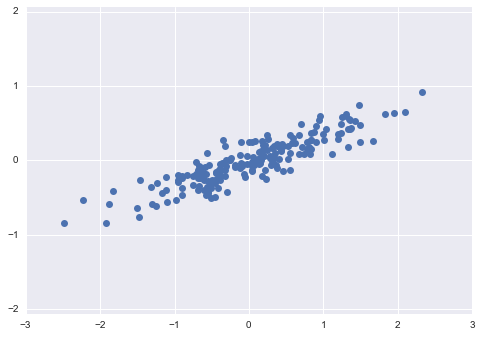

In [2]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

We can see that there is a definite trend in the data. What PCA seeks to do is to find the **Principal Axes** in the data, and explain how important those axes are in describing the data distribution:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)

[ 0.75871884  0.01838551]
[[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


To see what these numbers mean, let's view them as vectors plotted on top of the data:

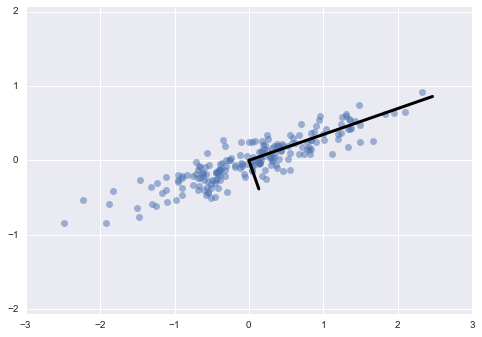

In [4]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [5]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(200, 2)
(200, 1)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

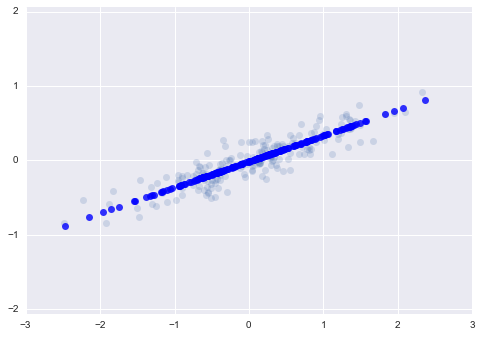

In [6]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.  We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%!

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

### Application of PCA to Digits

The dimensionality reduction might seem a bit abstract in two dimensions, but the projection and dimensionality reduction can be extremely useful when visualizing high-dimensional data.  Let's take a quick look at the application of PCA to the digits data we looked at before:

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [8]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797, 64)
(1797, 2)


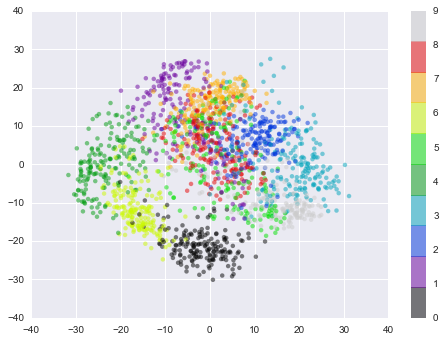

In [9]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

This gives us an idea of the relationship between the digits. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits, **without reference** to the labels.

### What do the Components Mean?

PCA is a very useful dimensionality reduction algorithm, because it has a very intuitive interpretation via *eigenvectors*.
The input data is represented as a vector: in the case of the digits, our data is

$$
x = [x_1, x_2, x_3 \cdots]
$$

but what this really means is

$$
image(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots
$$

If we reduce the dimensionality in the pixel space to (say) 6, we recover only a partial image:

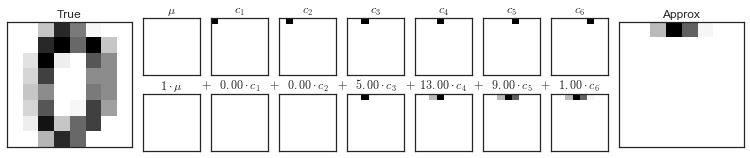

In [11]:
from figures import plot_image_components

sns.set_style('white')
plot_image_components(digits.data[0])

But the pixel-wise representation is not the only choice. We can also use other *basis functions*, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

What PCA does is to choose optimal **basis functions** so that only a few are needed to get a reasonable approximation.
The low-dimensional representation of our data is the coefficients of this series, and the approximate reconstruction is the result of the sum:

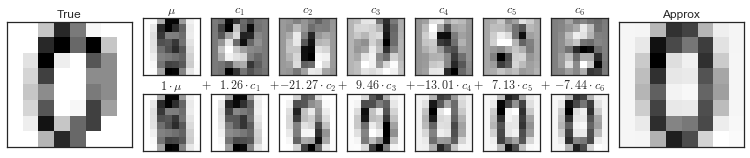

In [12]:
from figures import plot_pca_interactive
plot_pca_interactive(digits.data)

Here we see that with only six PCA components, we recover a reasonable approximation of the input!

Thus we see that PCA can be viewed from two angles. It can be viewed as **dimensionality reduction**, or it can be viewed as a form of **lossy data compression** where the loss favors noise. In this way, PCA can be used as a **filtering** process as well.

### Choosing the Number of Components

But how much information have we thrown away?  We can figure this out by looking at the **explained variance** as a function of the components:

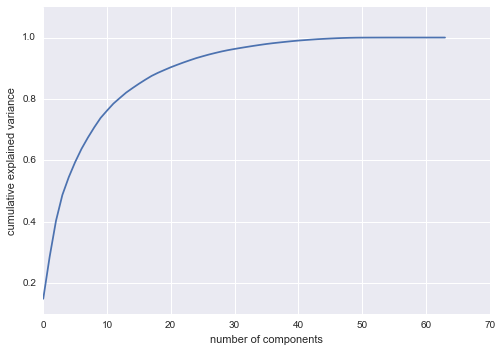

In [13]:
sns.set()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

### PCA as data compression

As we mentioned, PCA can be used for is a sort of data compression. Using a small ``n_components`` allows you to represent a high dimensional point as a sum of just a few principal vectors.

Here's what a single digit looks like as you change the number of components:

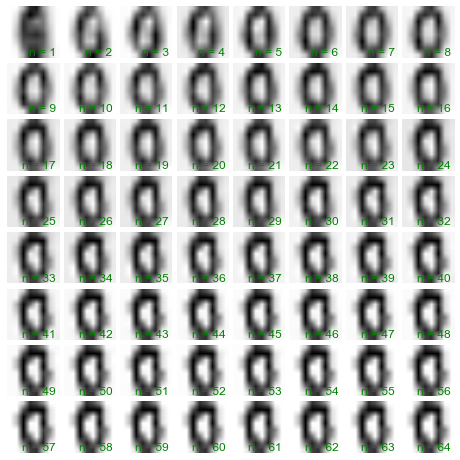

In [14]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[20:21]))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

Let's take another look at this by using IPython's ``interact`` functionality to view the reconstruction of several images at once:

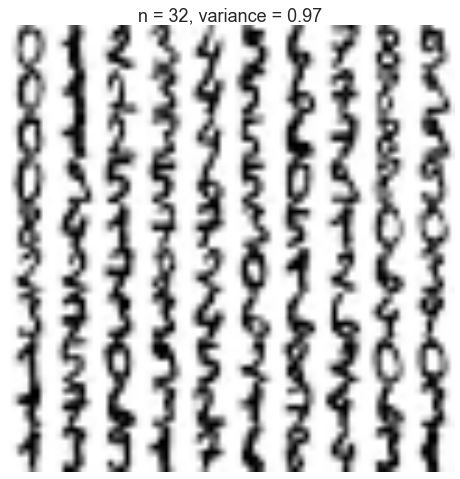

In [15]:
from IPython.html.widgets import interact

def plot_digits(n_components):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 1, 1, frameon=False, xticks=[], yticks=[])
    nside = 10
    
    pca = PCA(n_components).fit(X)
    Xproj = pca.inverse_transform(pca.transform(X[:nside ** 2]))
    Xproj = np.reshape(Xproj, (nside, nside, 8, 8))
    total_var = pca.explained_variance_ratio_.sum()
    
    im = np.vstack([np.hstack([Xproj[i, j] for j in range(nside)])
                    for i in range(nside)])
    plt.imshow(im)
    plt.grid(False)
    plt.title("n = {0}, variance = {1:.2f}".format(n_components, total_var),
                 size=18)
    plt.clim(0, 16)
    
interact(plot_digits, n_components=[1, 64], nside=[1, 8]);

## Other Dimensionality Reducting Routines

Note that scikit-learn contains many other unsupervised dimensionality reduction routines: some you might wish to try are
Other dimensionality reduction techniques which are useful to know about:

- [sklearn.decomposition.PCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.PCA.html): 
   Principal Component Analysis
- [sklearn.decomposition.RandomizedPCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.RandomizedPCA.html):
   extremely fast approximate PCA implementation based on a randomized algorithm
- [sklearn.decomposition.SparsePCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.SparsePCA.html):
   PCA variant including L1 penalty for sparsity
- [sklearn.decomposition.FastICA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.FastICA.html):
   Independent Component Analysis
- [sklearn.decomposition.NMF](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.NMF.html):
   non-negative matrix factorization
- [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html):
   nonlinear manifold learning technique based on local neighborhood geometry
- [sklearn.manifold.IsoMap](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.Isomap.html):
   nonlinear manifold learning technique based on a sparse graph algorithm
   
Each of these has its own strengths & weaknesses, and areas of application. You can read about them on the [scikit-learn website](http://sklearn.org).

## Exercise
Compare PCA with NMF: how different are the components (clue: "parts" for NMF)?

## Theorical background
- SVD and PCA


## Preprocessing
- scaling: http://scikit-learn.org/stable/modules/preprocessing.html
- normalization

## Related applications
- dimensionality reduction
- recommendation systems (collaborative filtering), look at SVD++ (https://github.com/gpfvic/IRR/blob/master/Factorization%20meets%20the%20neighborhood-%20a%20multifaceted%20collaborative%20filtering%20model.pdf)
- **PCA whitening**: http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/
- other spectral algorithms: pageRank, spectral clustering...